In [1]:
!pip install --upgrade pip

     |████████████████████████████████| 1.5 MB 404 kB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.1.1
    Uninstalling pip-20.1.1:
      Successfully uninstalled pip-20.1.1


In [2]:
# # !pip install 
# ! pip install --upgrade --force-reinstall --no-deps torch==1.6.0

In [20]:
!pip install --no-deps '../input/timm-package/timm-0.1.26-py3-none-any.whl' > /dev/null
!pip install --no-deps '../input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl' > /dev/null

In [8]:
! pip install --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ../input/nvidiaapex/.
from apex import amp

/opt/conda/lib/python3.7/site-packages/pip/_internal/commands/install.py:236: UserWarning: Disabling all use of wheels due to the use of --build-option / --global-option / --install-option.
  cmdoptions.check_install_build_global(options)
Processing /kaggle/input/nvidiaapex
Skipping wheel build for apex, due to binaries being disabled for it.
    Running setup.py install for apex ... done


In [9]:
!pip install adamp

  Created wheel for adamp: filename=adamp-0.2.0-py3-none-any.whl size=5997 sha256=a77123da7b18f247730835769599e17839d1856b061717075f9b7b62487b9818
  Stored in directory: /root/.cache/pip/wheels/f6/1b/9f/a2700c500a503d293c7c4b127987d59ee07fe9e8252b5fa109
Successfully built adamp


In [21]:
import sys
sys.path.insert(0, "../input/timm-efficientdet-pytorch")
sys.path.insert(0, "../input/omegaconf")

In [11]:
import numpy as np 
import pandas as pd 
import re, os, random
import torch, torchvision
import cv2
from glob import glob
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import StratifiedKFold
from torch.utils.data.sampler import SequentialSampler, RandomSampler

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from adamp import SGDP

device = torch.device('cuda')

SEED = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [12]:
# read the csv

TRAIN_DIR = '/kaggle/input/global-wheat-detection/train/'
TEST_DIR = '/kaggle/input/global-wheat-detection/test/'
SAVE_DIR = '/kaggle/working/'

# csv = '/kaggle/input/global-wheat-detection/train.csv'
csv = '/kaggle/input/boxes-repaired/train_clean.csv'

df = pd.read_csv(csv)
df.head()

,Unnamed: 0,image_id,width,height,bbox,source,x,y,w,h,area
0,0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1,834.0,222.0,56.0,36.0,2016.0
1,1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1,226.0,548.0,130.0,58.0,7540.0
2,2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1,377.0,504.0,74.0,160.0,11840.0
3,3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1,834.0,95.0,109.0,107.0,11663.0
4,4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1,26.0,144.0,124.0,117.0,14508.0


In [13]:
class WheatDataset(Dataset):
    
    def __init__(self, data_dir, dataframe, image_ids, transforms=None, valid=False):
        super().__init__()

        self.image_ids = image_ids
        self.df = dataframe
        self.transforms = transforms
        self.train_dir = data_dir
        self.valid = valid

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        if self.valid or random.random() > 0.5:
            image, boxes = self.load_image_and_boxes(index)
        else:
            image, boxes = self.load_cutmix_image_and_boxes(index)

        # there is only one class
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    break

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{self.train_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.df[self.df['image_id'] == image_id]
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return image, boxes

    def load_cutmix_image_and_boxes(self, index, imsize=1024):
        """ 
        This implementation of cutmix author:  https://www.kaggle.com/nvnnghia 
        Refactoring and adaptation: https://www.kaggle.com/shonenkov
        """
        w, h = imsize, imsize
        s = imsize // 2
    
        xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  # center x, y
        indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]

        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []

        for i, index in enumerate(indexes):
            image, boxes = self.load_image_and_boxes(index)
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b

            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
        return result_image, result_boxes

In [14]:
# 5 folds

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df_folds = df[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = df[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [15]:
def get_train_transforms():
    return A.Compose(
        [
            A.RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.5),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
              A.RandomGamma(p=0.5),
              A.GaussNoise(p=0.5,var_limit=(0, 0.2)),
              A.GaussianBlur(p=0.6),
              A.IAASharpen(p=0.5),
              A.RandomShadow(p=0.3)
            ],p=0.9),
            A.ToGray(p=0.1),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
            A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def collate_fn(batch):
    return tuple(zip(*batch))

In [16]:
BATCH_SIZE = 8
NUM_WORKERS = 16
fold_number = 0

train_dataset = WheatDataset(
    image_ids=df_folds[df_folds['fold'] != fold_number].index.values,
    data_dir=TRAIN_DIR,
    dataframe=df,
    transforms=get_train_transforms()
)
train_dataloader = DataLoader(train_dataset, 
                              batch_size=BATCH_SIZE,
                              sampler=RandomSampler(train_dataset),
                              num_workers=NUM_WORKERS,
                              collate_fn=collate_fn)

validation_dataset = WheatDataset(
    image_ids=df_folds[df_folds['fold'] == fold_number].index.values,
    data_dir=TRAIN_DIR,
    dataframe=df,
    transforms=get_valid_transforms()
)

valid_dataloader = DataLoader(validation_dataset, 
                              batch_size=4,
                              sampler=SequentialSampler(validation_dataset),
                              shuffle=False, 
                              num_workers=NUM_WORKERS,
                              collate_fn=collate_fn)

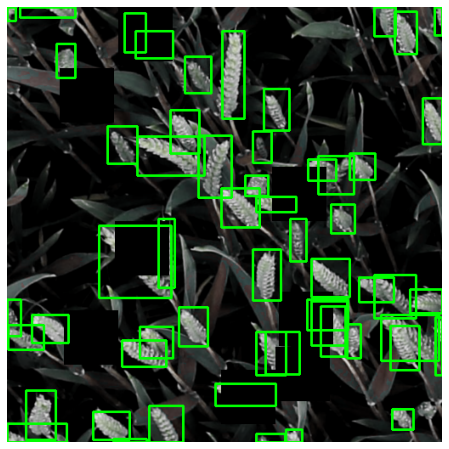

In [17]:
# test image

image, target, _ = train_dataset[30]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)

ax.set_axis_off()
ax.imshow(numpy_image);

In [18]:
print('Train Dataset {}'.format(len(train_dataset)))

Train Dataset 2698


In [27]:
# model_loc = '../input/train-efficientdet-like-yolo-v5/effdet5-cutmix/best-checkpoint-075epoch.bin'
# checkpoint = torch.load(model_loc)

from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet

def get_net(my_checkpoint=None):
    config = get_efficientdet_config('tf_efficientdet_d3')
    net = EfficientDet(config, pretrained_backbone=False)
    config.num_classes = 1
    config.image_size = 512
    net.class_net = HeadNet(config, num_outputs=1, norm_kwargs=dict(eps=.001, momentum=.01))
#     net.load_state_dict(my_checkpoint['model_state_dict'])
    tr = DetBenchTrain(net, config)

    return tr
    
model = get_net() # checkpoint
model.to(device)
print('done')

done


In [28]:
# metric

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [29]:
def save_model(path, val_loss):
    model.eval()
    torch.save({
                'model_state_dict': model.model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': lr_scheduler.state_dict(),
                'best-prev-loss': val_loss
            }, path)

In [30]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience.
       by https://github.com/Bjarten/early-stopping-pytorch"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, val_loss):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [31]:
#  load prev trained model

model.train()
params = [p for p in model.parameters() if p.requires_grad]

# optimizer = torch.optim.AdamW(params, lr=0.001, weight_decay=0.0001)
optimizer = SGDP(params, lr=0.07, weight_decay=0.0001, momentum=0.9, nesterov=True)

early_stopping = EarlyStopping(patience=5, verbose=True)

# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=6, eta_min=0, last_epoch=-1)

model, optimizer = amp.initialize(model, optimizer, opt_level="O1", verbosity=0)

# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# lr_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

In [32]:
%%time

num_epochs = 1
Training_losses = []
summary_loss = AverageMeter()
best_loss = 1.5 # checkpoint['best-prev-loss']
Valid_losses = []
prev_epoch = 0
grad_acc_steps = 8

for epoch in range(num_epochs):
    summary_loss.reset()
    for step, (images, targets, _) in enumerate(train_dataloader):
        
        images = torch.stack(images)
        images = images.to(device)
        boxes = [target['boxes'].to(device).float() for target in targets]
        labels = [target['labels'].to(device).float() for target in targets]
        
        loss_dict, _, _ = model(images, boxes, labels)
        
        # mixed precision training
        with amp.scale_loss(loss_dict, optimizer) as scaled_loss:
            scaled_loss.backward()
            
        # gradient accumulation
        if step % grad_acc_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            
        summary_loss.update(loss_dict.detach().item(), BATCH_SIZE)  

    Training_losses.append(summary_loss.avg)    
    summary_loss.reset()
    
    for images, targets, _ in valid_dataloader:
        
        images = torch.stack(images)
        images = images.to(device)
        boxes = [target['boxes'].to(device).float() for target in targets]
        labels = [target['labels'].to(device).float() for target in targets]

        loss_dict, _, _ = model(images, boxes, labels)
        summary_loss.update(loss_dict.detach().item(), BATCH_SIZE)

    Valid_losses.append(summary_loss.avg)
    print(f"Epoch #{epoch+1+prev_epoch} training_loss: {Training_losses[-1]}  valid_loss: {Valid_losses[-1]}")    
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
   
    # early stoping
    early_stopping(Valid_losses[-1])
    if early_stopping.early_stop:
        print("Early stopping")
        break

    if best_loss > Valid_losses[-1]:

        best_loss = Valid_losses[-1]
        save_model(f'{SAVE_DIR}/best-checkpoint-{str(epoch+1+prev_epoch).zfill(3)}epoch.bin', best_loss)
        # remove previous more than 3 saves
        for path in sorted(glob(f'{SAVE_DIR}/best-checkpoint-*epoch.bin'))[:-3]:
             os.remove(path)

/opt/conda/conda-bld/pytorch_1591914880026/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


Epoch #1 training_loss: 3.6975139964967085  valid_loss: 4.971683606593566
CPU times: user 4min, sys: 18.5 s, total: 4min 19s
Wall time: 8min 43s


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:114: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


In [ ]:
# last checkpoint
save_model(f'{SAVE_DIR}/last-checkpoint-{str(prev_epoch+1+epoch).zfill(3)}epoch.bin', Valid_losses[-1])
print('Model Saved')